## Importing the input vectors

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run the data preparation notebook
X_lstm = np.load("npy_files/X_lstm.npy")
anomaly_list = np.load("npy_files/anomaly_list.npy") #0 for normal. 1 for anomaly


In [77]:
pd.DataFrame(X_lstm[0,:,:])

,0,1,2,3,4,5,6,7,8
0,0.798606,0.929178,0.000000,0.000675,0.000000,0.000000,0.0,0.000675,0.000675
1,0.822682,0.925587,0.000000,0.000810,0.000675,0.000000,0.0,0.000810,0.000810
2,0.909808,0.565838,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
3,0.859021,0.582722,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
4,0.736674,0.003256,0.013814,0.000000,0.003781,0.013814,0.0,0.003780,0.003780
5,0.673348,0.003283,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
6,0.795370,0.001674,0.013320,0.000135,0.003781,0.013320,0.0,0.003780,0.003780


#### Divide into train data and test data

In [82]:
# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_lstm

normal_train_data = np.empty((0, 7, 9))  # Empty array with correct shape
anomalous_train_data = np.empty((0, 7, 9))
normal_val_data = np.empty((0, 7, 9))
anomalous_val_data = np.empty((0, 7, 9))
normal_test_data = np.empty((0, 7, 9))
anomalous_test_data = np.empty((0, 7, 9))

# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
split_index = int(0.25 * len(labels))
split_index2 = int(0.44 * len(labels))
split_index3 = int(0.63 * len(labels))

# Split the data and labels
train_data = np.concatenate((data[:split_index], data[split_index3:]), axis=0)
val_data = data[split_index:split_index2]
test_data = data[split_index2:split_index3]

train_labels = np.concatenate((labels[:split_index], labels[split_index3:]), axis=0)
val_labels = labels[split_index:split_index2]
test_labels = labels[split_index2:split_index3]

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Pass to float
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


for i in range(len(train_labels)):
     if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :, :]), axis=0)
     else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :, :]), axis=0)

for i in range(len(val_labels)):
       if val_labels[i] == 0:
         normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :, :]), axis=0)
       else:
         anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :, :]), axis=0)

for i in range(len(test_labels)):
     if test_labels[i] == 0:
        normal_test_data = np.concatenate((normal_test_data, test_data[i:i+1, :, :]), axis=0)
     else:
        anomalous_test_data = np.concatenate((anomalous_test_data, test_data[i:i+1, :, :]), axis=0)


#### Deciding the different sets' sizes and positions

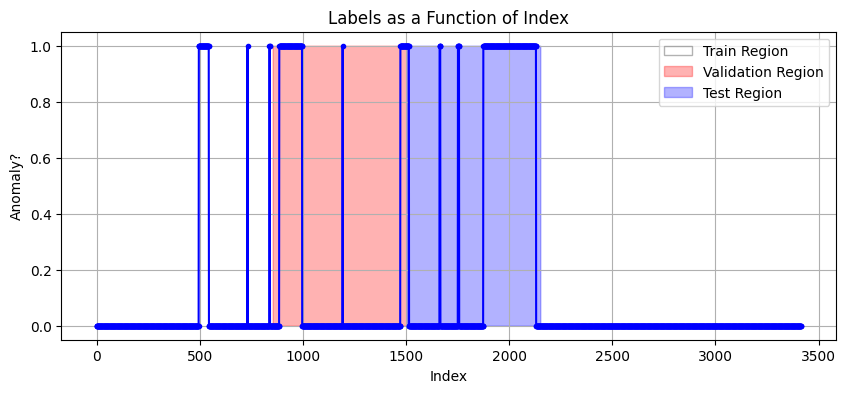

In [101]:
from matplotlib.patches import Patch
labels_int = [int(label) for label in labels]

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, 'b.-', label='Labels')
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index) & (np.arange(len(labels)) < split_index2), color='red', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index2) & (np.arange(len(labels)) < split_index3), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='white', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels as a Function of Index')
plt.grid(True)
plt.show()

In [95]:
from collections import Counter
def calculate_proportions(labels):
    counter = Counter(labels)
    total = len(labels)
    true_proportion = counter[True] / total
    false_proportion = counter[False] / total
    return true_proportion, false_proportion

# Calculate proportions for each list
train_true_prop, train_false_prop = calculate_proportions(train_labels)
val_true_prop, val_false_prop = calculate_proportions(val_labels)
test_true_prop, test_false_prop = calculate_proportions(test_labels)
# Print the proportions
print(f"Train Labels ({len(train_labels)} samples) -     Normal: {train_false_prop*100:.2f}%, Anomalous: {train_true_prop*100:.2f}%")
print(f"Validation Labels ({len(val_labels)} samples) - Normal: {val_false_prop*100:.2f}%, Anomalous: {val_true_prop*100:.2f}%")
print(f"Test Labels ({len(test_labels)} samples) -       Normal: {test_false_prop*100:.2f}%, Anomalous: {test_true_prop*100:.2f}%")



Train Labels (2118 samples) -     Normal: 97.50%, Anomalous: 2.50%
Validation Labels (649 samples) - Normal: 78.12%, Anomalous: 21.88%
Test Labels (649 samples) -       Normal: 57.16%, Anomalous: 42.84%


## Autoencoder

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 48.6785 - val_loss: 16.2530
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.0890 - val_loss: 9.0244
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1566 - val_loss: 5.7305
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2936 - val_loss: 3.8956
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6369 - val_loss: 2.7571
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5928 - val_loss: 2.0034
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8929 - val_loss: 1.4835
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4042 - val_loss: 1.1156
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0585 - val_loss: 0.8500
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8076 - val_loss: 0.6553
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6240 - val_loss: 0.5104
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - los

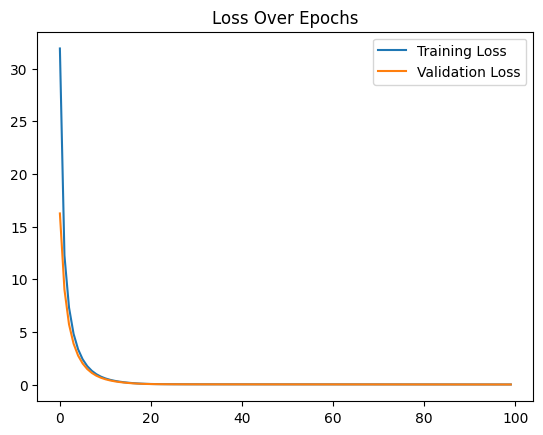

In [102]:
# Define input dimension
timesteps = normal_train_data.shape[1]
features = normal_train_data.shape[2]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(timesteps, features), name='input')
encoded = LSTM(32, return_sequences=True, activation='sigmoid', name='encoder_1')(input_layer)
encoded = LSTM(16, return_sequences=False, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = RepeatVector(timesteps, name='repeat_vector')(encoded)
decoded = LSTM(16, return_sequences=True, activation='sigmoid', name='decoder_1')(decoded)
decoded = LSTM(32, return_sequences=True, activation='sigmoid', name='decoder_2')(decoded)
output_layer = TimeDistributed(Dense(features), name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder_1' in layer.name or 'bottleneck' in layer.name 
                         or 'decoder_1' in layer.name or 'decoder_2' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            rho_hat = tf.clip_by_value(rho_hat, 1e-5, 1 - 1e-5)
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-5)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-5))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data,  # Input and target are the same for autoencoders
    y=normal_train_data,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_val_data, normal_val_data)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Threshold:  0.06101007553909557
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


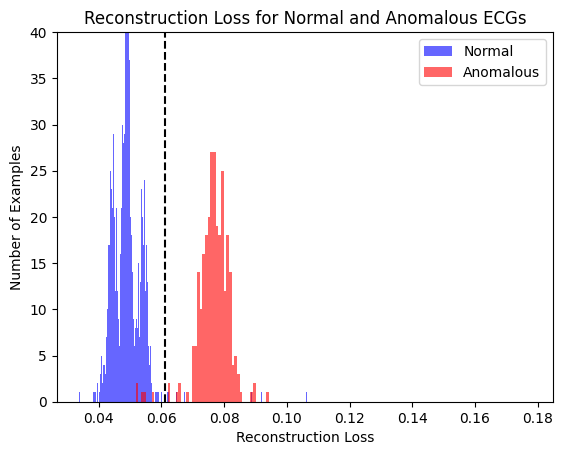

Accuracy = 98.15100154083206%
Precision = 98.6449864498645%
Recall = 98.11320754716981%
F1 Score = 98.37837837837839%


In [109]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_train_data)
train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_normal, normal_train_data), axis=1)


threshold = np.mean(train_loss) + 2*np.std(train_loss)
print("Threshold: ", threshold)
#threshold=0.062 ########################################################################################################################################################

reconstructions_anomalous = autoencoder.predict(anomalous_test_data)
test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_anomalous, anomalous_test_data), axis=1)

# Plot both losses on the same histogram
plt.hist(train_loss, bins=1000, alpha=0.6, color='blue', label='Normal')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous ECGs")
plt.axvline(x=threshold, color='black', linestyle='--')
plt.ylim((0, 40))
#plt.xlim((0,1))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

In [110]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(~test_labels, preds)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[273   5]
 [  7 364]]


Confusion Matrix (sklearn):\
\
$\begin{pmatrix}
\textrm{True negatives} & \textrm{False positives}\\
\textrm{False negatives} & \textrm{True positives}\\
\end{pmatrix}$